#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [3]:
class Chromosome:
  def __init__(self, length, array=None):
    self.array = array if array is not None else np.random.randint(2, size=length)
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi):
    gene_segment = self.array[lower_bound:upper_bound]
    total_val = int("".join(map(str, gene_segment)), 2)
    decoded_value = min_max_norm(total_val, 0, pow(2, len(gene_segment))-1, aoi[0], aoi[1])
    return decoded_value

  def mutation(self, probability):
    if np.random.random() < probability:
        mutation_index = np.random.randint(0, self.length)
        self.array[mutation_index] = int(not(self.array[mutation_index]))

  def crossover(self, other):
    cross_point = np.random.randint(1, self.length)
    first_array = np.concatenate((self.array[:cross_point], other.array[cross_point:]))
    second_array = np.concatenate((other.array[:cross_point], self.array[cross_point:]))
    first_child = Chromosome(self.length, first_array)
    second_child = Chromosome(self.length, second_array)
    return first_child, second_child

In [4]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_length = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population_size = population_size
    self.population = [Chromosome(self.chromosome_length) for _ in range(self.population_size)]

  def eval_objective_func(self, chromosome):
    args = []
    for i in range(self.obj_func_num_args):
        start = i * self.bits_per_arg
        end = start + self.bits_per_arg
        args.append(chromosome.decode(start, end, self.aoi))
    func_value = self.objective_function(*args)
    return {"args": args, "value": func_value}

  def tournament_selection(self):
    selected = []
    for _ in range(self.population_size):
        competitors = np.random.choice(self.population, self.tournament_size)
        selected.append(min(competitors, key=lambda chrom: self.eval_objective_func(chrom)["value"]))
    return selected

  def reproduce(self, parents):
    next_generation = []
    for i in range(0, self.population_size, 2):
        parent1, parent2 = parents[i], parents[i + 1]
        if np.random.random() < self.crossover_probability:
            child1, child2 = parent1.crossover(parent2)
            next_generation += [child1, child2]
        else:
            next_generation += [parent1, parent2]

    for individual in next_generation:
      individual.mutation(self.mutation_probability)

    return next_generation

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Genetic algorithm")
    plt.show()

  def run(self, verbose=False):
    trace = []
    best_in_generation = []

    for step in range(self.num_steps):
        parents = self.tournament_selection()
        self.population = self.reproduce(parents)
        best_chromosome = min(self.population, key=lambda chrom: self.eval_objective_func(chrom)["value"])
        decoded = self.eval_objective_func(best_chromosome)
        trace.append(decoded["args"])
        best_in_generation.append((step, decoded["args"], decoded["value"]))
    self.plot_func(trace)
    if verbose:
      for best in best_in_generation:
        print(f"Step: {best[0]+1}, arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(self.objective_function(*[0,0])-best[2])}")
    return best_in_generation[self.num_steps-1]

In [5]:
def objective_function(x1, x2):
    return 1.5 - np.exp(-x1**2 - x2**2) - 0.5 * np.exp(-(x1 - 1)**2 - (x2 + 2)**2)

**Parametry domyślne**
*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 1000
*   num_steps = 30





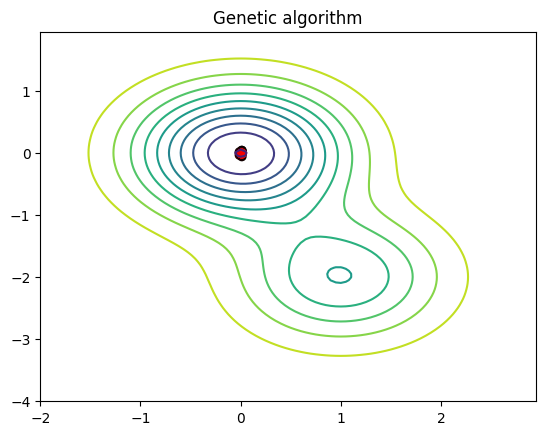

Arguments: x=0.0118, y=-0.0118, function value: 0.4967, error: 3.137474836600873e-05


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=1000, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

**Zmiana rozmiaru populacji**
*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30

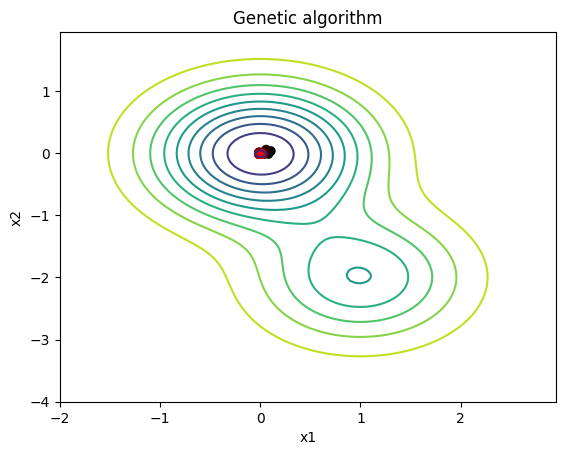

Arguments: x=0.0118, y=-0.0118, function value: 0.4967, error: 3.137474836600873e-05


In [6]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 100
*   num_steps = 30

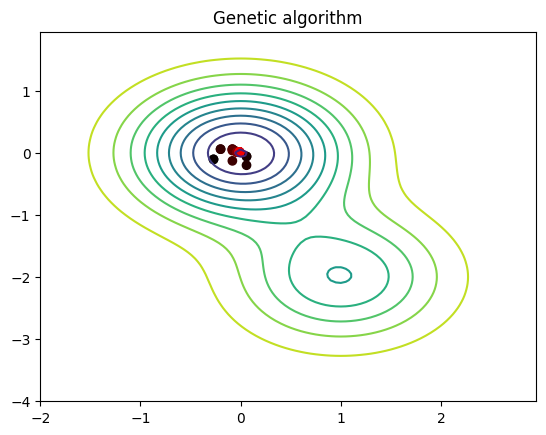

Arguments: x=-0.0118, y=0.0118, function value: 0.4971, error: 0.0005072578627376423


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=100, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 20
*   num_steps = 30

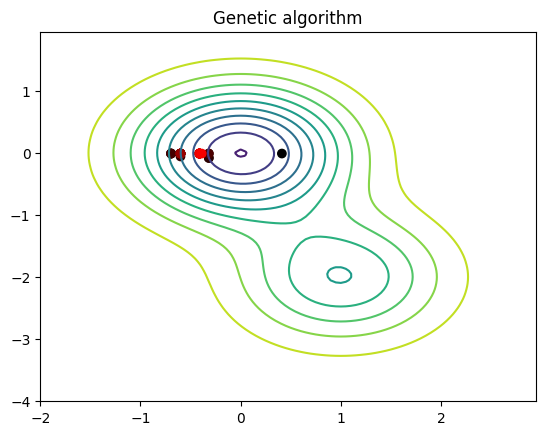

Arguments: x=-0.3882, y=-0.0118, function value: 0.6386, error: 0.1420082263305394


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=20, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

**Zmiana liczby kroków (liczby pokoleń)**
*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 100

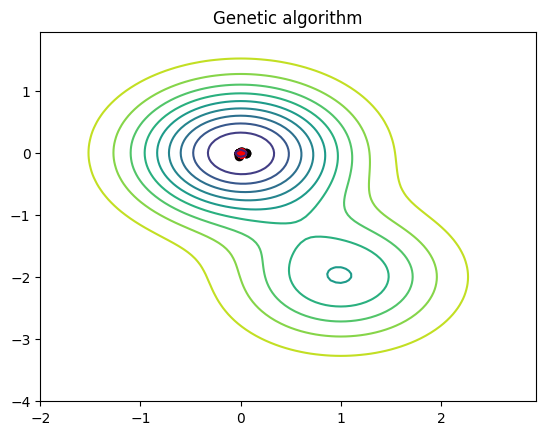

Arguments: x=0.0118, y=-0.0118, function value: 0.4967, error: 3.137474836600873e-05


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=100)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 10

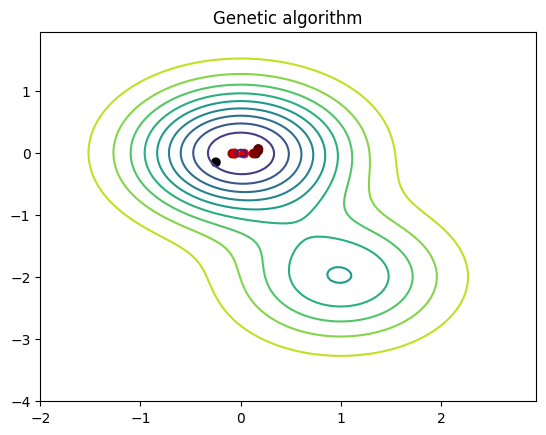

Arguments: x=0.0353, y=-0.0118, function value: 0.4976, error: 0.0009677607515424236


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=10)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

**Zmiana długości chromosomu**
*   chromosome_length = 8
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30

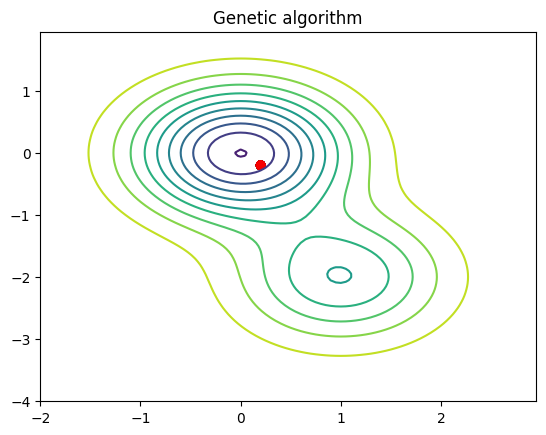

Arguments: x=0.2000, y=-0.2000, function value: 0.5666, error: 0.0699272145220508


In [ ]:
ga = GeneticAlgorithm(chromosome_length=8, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 8
*   aoi = [-1, 1] (mniejszy zakres)
*   population_size = 500
*   num_steps = 30

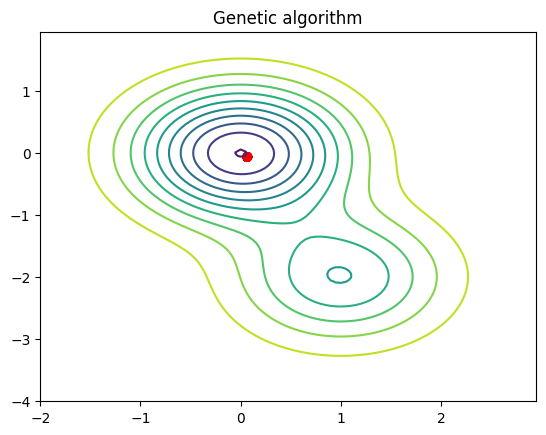

Arguments: x=0.0667, y=-0.0667, function value: 0.5039, error: 0.007237031996698062


In [ ]:
ga = GeneticAlgorithm(chromosome_length=8, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-1, 1], population_size=500, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 32
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30

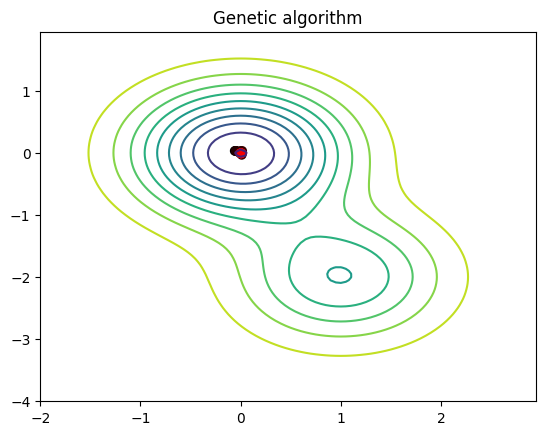

Arguments: x=0.0035, y=-0.0069, function value: 0.4966, error: 5.853885827383776e-05


In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 128
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30

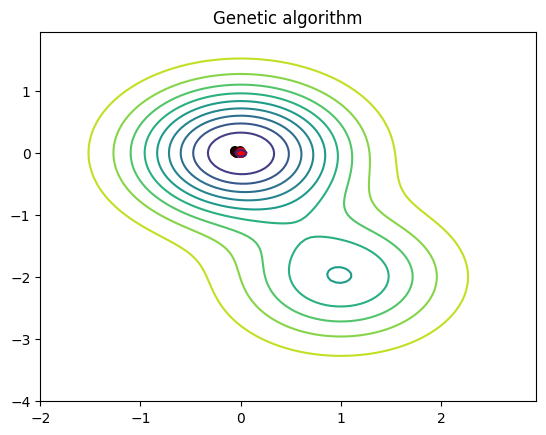

Arguments: x=0.0035, y=0.0000, function value: 0.4966, error: 1.1026918630308025e-05


In [ ]:
ga = GeneticAlgorithm(chromosome_length=128, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

**Zmiana prawdopodobieństwa mutacji**
*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30
*   mutation_probability = 0.2




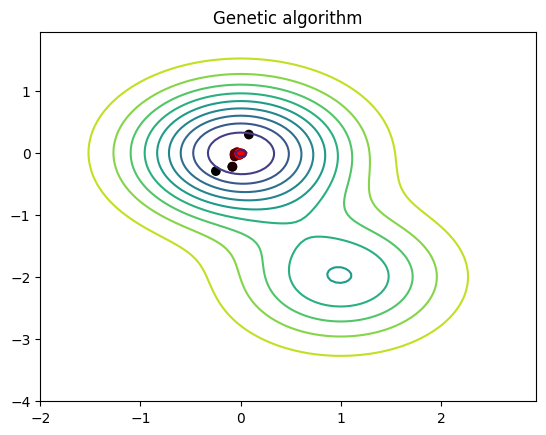

Arguments: x=-0.0118, y=-0.0118, function value: 0.4968, error: 0.00019752304777198582


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, mutation_probability=0.2, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 16
*   aoi = [-5, 5]
*   population_size = 200 (zmniejszona populacja)
*   num_steps = 30
*   mutation_probability = 0.7

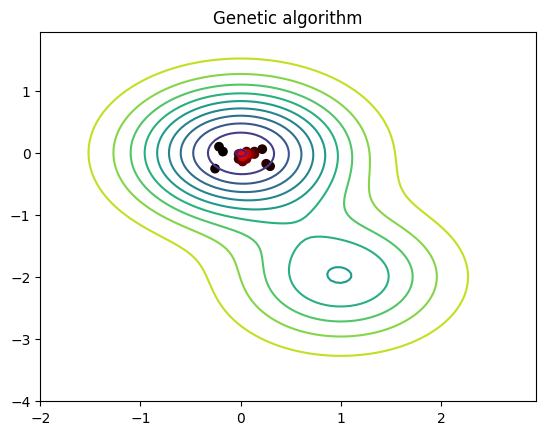

Arguments: x=0.0196, y=-0.0196, function value: 0.4970, error: 0.0003509459335261367


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-5, 5], population_size=200, mutation_probability=0.7, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

**Zmiana prawdopodobieństwa krzyżowania**
*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 500
*   num_steps = 30
*   crossover_probability = 0.5


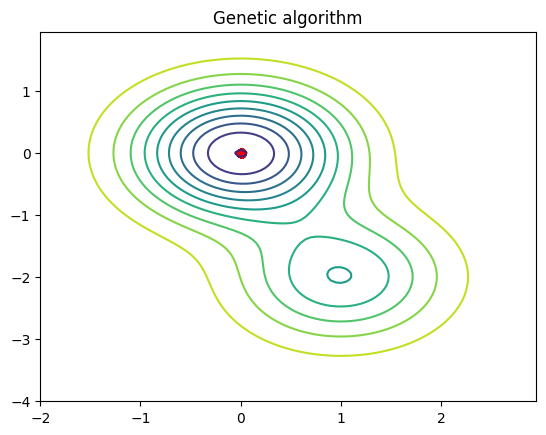

Arguments: x=0.0118, y=-0.0118, function value: 0.4967, error: 3.137474836600873e-05


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=500, crossover_probability=0.5, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

*   chromosome_length = 16
*   aoi = [-3, 3]
*   population_size = 200
*   num_steps = 30
*   crossover_probability = 0.1

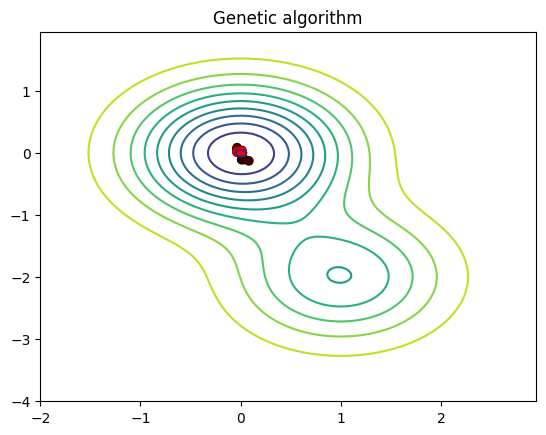

Arguments: x=0.0118, y=0.0118, function value: 0.4970, error: 0.00035603372193471206


In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function,
    aoi=[-3, 3], population_size=200, crossover_probability=0.1, num_steps=30)
best = ga.run(False)
print(f"Arguments: x={best[1][0]:.4f}, y={best[1][1]:.4f}, function value: {best[2]:.4f}, error: {abs(objective_function(*[0,0])-best[2])}")

#Wnioski

**Metoda gradientowa a algorytm genetyczny**

Oba algorytmy są w stanie znaleźć minimum zadanej funkcji w punkcie (0,0) z podobną dokładnością, rzędu 10^(-5). Główną różnicą między tymi algorytmami jest jednak fakt, że algorytm genetyczny jest w stanie skutecznie znaleźć minimum globalne zadanej funkcji, podczas gdy metoda spadku gradientu może utknąć w minimum lokalnym i nie znaleźć minimum globalnego. Istotną rolę odgrywa również losowość - algorytm genetyczny może uzyskać rozwiązania różniące się od siebie błędem, ponieważ działanie algorytmu zależne jest od prawdopodobieństwa mutacji oraz krzyżowania.

**Parametry algorytmu genetycznego**

**Zmiana populacji** - im mniejsza jest liczba populacji, tym szybsze jest działanie algorytmu, lecz zmniejsza się różnorodność i uzyskane rozwiązanie ma większy błąd. Większa populacja zwiększa szansę na "trafienie" w lepszy obszar i uzyskanie bardziej dokładnego wyniku.

**Zmiana liczby pokoleń** - więcej pokoleń daje algorytmowi więcej czasu na znalezienie optymalnego rozwiązania i może umożliwić bardziej dokładne zbliżenie się do globalnego minimum.

**Zmiana długości chromosomu** - dłuższy chromosom pozwala na bardziej precyzyjne reprezentowanie wartości zmiennych wejściowych funkcji celu, co może zwiększyć dokładność wyników. Jednak wzrost długości chromosomu zwiększa złożoność obliczeniową algorytmu, co wydłuża czas jego działania i ponadto zwiększa przestrzeń rozwiązań, co może wymagać większej liczby pokoleń, aby algorytm skutecznie odnalazł optymalne rozwiązanie.

**Zmiana prawdopodobieństwa mutacji** - większe prawdopodobieństwo mutacji wprowadza więcej losowych zmian do genotypów osobników, co zwiększa eksplorację i różnorodność. Jednak zbyt wysoka mutacja może zakłócić proces optymalizacji, powodując zbyt losowe przeszukiwanie.

**Zmiana prawdopodobieństwa krzyżowania** - zmniejszenie prawdopodobieństwa krzyżowania oznacza, że mniej par osobników będzie się wymieniało genami, co prowadzi do mniejszej różnorodności genetycznej w populacji. Oznacza to, że algorytm będzie bardziej eksploatował już znane rozwiązania i będzie potrzebował większej ilości pokoleń, aby znaleźć lepsze rozwiązanie.

